In [1]:
import pandas as pd
import numpy as np
from stop_words import get_stop_words
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.textpath import TextPath
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn import mixture
from collections import Counter
from sklearn.cluster import DBSCAN

In [94]:
#vereinfachte Methode:
def linkage_matrix(n_samples, children, distances):
    """
    create a linkage matrix for the dendogram method in scipy
    n_samples: int, number of samples
    children: list of lists, clustered data points (should be 2)
    distances: list of distances between nodes
    """
    # Create linkage matrix
    

    # create the counts of samples under each node
    counts = np.zeros(children.shape[0])
    for i, merge in enumerate(children):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack([children, distances, counts]).astype(float)

# Gibt eine Worthäufigkeitsliste zurück, mit nur dem Namen des Genre in Form eines Strings als Argument.
def wordlister(genre):
    stop_words = get_stop_words('de')
    stop_words.append('ch00ffff')
    # Alle Texte eines Genres konkatenieren
    film_genre = ""
    for film in df.iterrows():
        if film[1].genre == genre:
            film_genre = film_genre + film[1].text
    # Tokenisieren
    genre_tokens = re.findall("\w+", film_genre.lower())
    # Stopwordliste 
    tokens_without_stopwords =[]
    for word in genre_tokens:
        if word not in stop_words:
            tokens_without_stopwords.append(word)
    #Rückgabe mit gezählten Tokens
    return Counter(tokens_without_stopwords)


def wordlister_Language(genre):
    stop_words = get_stop_words('de')
    stop_words.append('ch00ffff')
    # Alle Texte eines Genres konkatenieren
    film_genre = ""
    for film in df_sample.iterrows():
        if film[1].Language == genre:
            film_genre = film_genre + film[1].text
    # Tokenisieren
    genre_tokens = re.findall("\w+", film_genre.lower())
    # Stopwordliste 
    tokens_without_stopwords =[]
    for word in genre_tokens:
        if word not in stop_words:
            tokens_without_stopwords.append(word)
    #Rückgabe mit gezählten Tokens
    return Counter(tokens_without_stopwords)

# Plottet die Wörterliste aus der oberen Funktion, mit .most_common() kann die Zahl begrenzt werden.
def wordlistplot(wordlist):
    plt.figure(figsize=(15,8))
    for word in wordlist:
        x= word[0]
        y = word[1]
        plt.bar(x, y)
    plt.show()
    
# Gibt unter Angabe eines Filmtitels als String die Worthäufigkeitsliste des Films, seinen Text 
# und zur Metadatenabfrage die Series aus dem Dataframe zurück    
def wordlistersingle(title):
    singletitle = df.loc[(df['Title'] == title)]
    idx = df.index[df['Title'] == title]
    
    single_tokens = re.findall("\w+", singletitle.at[idx[0],'text'].lower())
    tokens_without_stopwords =[]
    for word in single_tokens:
        if word not in stop_words:
            tokens_without_stopwords.append(word)
    return Counter(tokens_without_stopwords), singletitle.at[idx[0],'text'], singletitle

Selbe Funktion, wie oben nur umgeschrieben für "Language"
def wordlistersingle_Language(title):
    singletitle = df_sample.loc[(df['Title'] == title)]
    idx = df_sample.index[df_sample['Title'] == title]
    
    single_tokens = re.findall("\w+", singletitle.at[idx[0],'text'].lower())
    tokens_without_stopwords =[]
    for word in single_tokens:
        if word not in stop_words:
            tokens_without_stopwords.append(word)
    return Counter(tokens_without_stopwords), singletitle.at[idx[0],'text'], singletitle
    
#Filter der NICHT Stop-Wörter herausfiltert.    
def filter_non_stopwords(s, stopwords=get_stop_words('de')):
    stopwords = set([t.lower() for t in stopwords])
    token = re.findall(r'\w+', s.lower())
    return " ".join([t for t in token if t in stopwords])

## Datensatz einlesen

In [3]:
df = pd.read_csv('../../dataset/movies_complete.csv')
df.dropna(subset=['genre'], inplace=True)
df.dropna(subset=['Language'], inplace=True)
df['text_length'] = df.text.apply(lambda x: len(x.split()))
df = df[df['text_length'] >= 3000]
df.shape

(3468, 56)

In [4]:
df['only_stopwords'] = df.text.apply(filter_non_stopwords)

# 1. Genre Cluster

In [7]:
genre_combination_frequs = Counter(df.genre)
genre_combination_frequs.most_common(30)

[('Drama', 367),
 ('Comedy', 194),
 ('Comedy,Drama', 137),
 ('Drama,Romance', 132),
 ('Comedy,Drama,Romance', 116),
 ('Comedy,Romance', 85),
 ('Horror', 77),
 ('Drama,Thriller', 74),
 ('Horror,Thriller', 69),
 ('Action,Crime,Drama', 67),
 ('Adventure,Animation,Comedy', 65),
 ('Documentary', 64),
 ('Crime,Drama,Thriller', 62),
 ('Thriller', 53),
 ('Action,Crime,Thriller', 49),
 ('Action,Comedy,Crime', 41),
 ('Action,Adventure,Sci-Fi', 41),
 ('Action', 36),
 ('Action,Adventure,Drama', 36),
 ('Crime,Drama', 34),
 ('Biography,Drama,History', 30),
 ('Biography,Drama', 30),
 ('Crime,Drama,Mystery', 30),
 ('Action,Thriller', 28),
 ('Horror,Mystery,Thriller', 28),
 ('Action,Adventure,Comedy', 28),
 ('Comedy,Horror', 27),
 ('Comedy,Crime,Drama', 26),
 ('Action,Adventure,Fantasy', 25),
 ('Action,Adventure,Animation', 22),
 ('Crime,Thriller', 22),
 ('Family', 21),
 ('Action,Horror,Sci-Fi', 20),
 ('Biography,Drama,Romance', 20),
 ('Action,Comedy', 19),
 ('Action,Drama', 19),
 ('Action,Drama,Histor

## Vorbereitung der Label und Slice auf die Genre

In [135]:
#Documentary und Action, Crime, Drama
labelcolor = []
for index, row in df.iterrows():
    if (row['genre'] == 'Documentary') == True:                       #Documentary
        labelcolor.append('red')  
    elif (row['genre'] == 'Action,Crime,Drama') == True:              #Action,Crime,Drama
        labelcolor.append('blue')  
    else: 
        labelcolor.append('white')
df['labelcolor']=labelcolor    
df_2genre = df[df.labelcolor != 'white']
pd.value_counts(df_2genre.labelcolor)  

blue    67
red     64
Name: labelcolor, dtype: int64

## TFIDF - Agglomerative Clustering

In [124]:
#tf-idf
stop_words = get_stop_words('de')
stop_words.append('ch00ffff')
stop_words.append('¼')
tfidf = TfidfVectorizer(max_features=100, stop_words=stop_words)
tokens = tfidf.fit_transform(df_2genre.text)
hier_model = c(n_clusters=None, distance_threshold=0).fit(tokens.todense())

## Dendrogram

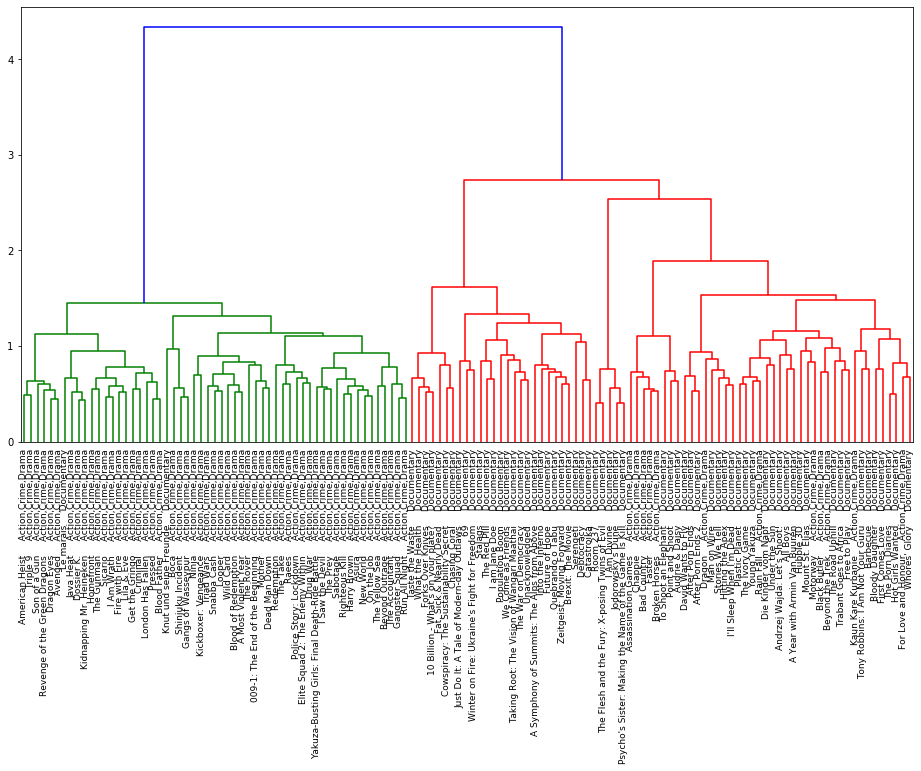

In [134]:
lmatrix = linkage_matrix(tokens.shape[0], hier_model.children_, hier_model.distances_)
plt.figure(figsize=(16,8))
dendrogram(lmatrix, labels=(df_2genre['Title'].values + "     " + df_2genre['genre'].values), leaf_font_size=9);

## Liste der Häufigsten Wortformen in den "Documentaries"

In [132]:
count_docu = wordlister('Documentary')
count_docu.most_common(20)

[('ja', 1383),
 ('mehr', 1268),
 ('immer', 1067),
 ('gibt', 969),
 ('wurde', 953),
 ('leben', 872),
 ('gut', 871),
 ('menschen', 840),
 ('mal', 773),
 ('leute', 742),
 ('sagte', 717),
 ('geht', 711),
 ('viele', 709),
 ('schon', 650),
 ('sehen', 649),
 ('einfach', 634),
 ('sagen', 618),
 ('weiß', 576),
 ('nein', 568),
 ('wirklich', 550)]

## Liste der häufigsten Wortformen in "Action, Crime, Drama"

In [133]:
count_action_crime_drama = wordlister('Action,Crime,Drama')
#print(wordlistplot(count_action_crime_drama.most_common(1000))) 
count_action_crime_drama.most_common(20)

[('ja', 3096),
 ('hast', 1536),
 ('nein', 1490),
 ('mal', 1380),
 ('schon', 1334),
 ('los', 1326),
 ('gut', 1317),
 ('s', 1177),
 ('hey', 927),
 ('geht', 895),
 ('mann', 879),
 ('wer', 848),
 ('komm', 836),
 ('weiß', 827),
 ('okay', 827),
 ('bitte', 766),
 ('mehr', 726),
 ('scheiße', 649),
 ('gehen', 638),
 ('immer', 635)]

## Liste der Wortformen in expliziten Titeln zum Vergleich mit den Listen der Genre

In [84]:
count_singletitle, text_singletitle, df_singletitle = wordlistersingle('Assassination Games')
#Ghost in the Shell
#Le marais
count_singletitle.most_common(40)

[('ok', 26),
 ('hast', 24),
 ('polo', 24),
 ('flint', 22),
 ('geld', 20),
 ('roland', 20),
 ('schon', 14),
 ('mal', 14),
 ('gut', 14),
 ('kannst', 12),
 ('raus', 12),
 ('leben', 12),
 ('tun', 11),
 ('willst', 11),
 ('ja', 11),
 ('freund', 11),
 ('nein', 11),
 ('gibt', 10),
 ('bitte', 9),
 ('komm', 9),
 ('bruder', 9),
 ('hallo', 9),
 ('mann', 8),
 ('hey', 8),
 ('weiß', 8),
 ('lassen', 8),
 ('gehen', 8),
 ('stopp', 7),
 ('tut', 7),
 ('morgen', 7),
 ('lange', 7),
 ('wer', 7),
 ('s', 7),
 ('leid', 6),
 ('tot', 6),
 ('beide', 6),
 ('persönlich', 6),
 ('immer', 6),
 ('anna', 6),
 ('mehr', 6)]

## Als Action, Crime, Drama eingeordnet:
##### Le Marais: 
Dokumentation zeigt das alltägliche leben in Le Marais, die Dokumentation besteht hauptsächlich aus Dialogen mit den Leuten dort -> alltagssprache; häufigsten Wörter stimmen mehr mit Action, Crime Drama überein
##### Die Kinder vom Napf:
Alltagssprache, einfache Wörter, Dialoge mit Kindern -> enthält nicht die typische sachliche Sprache der meisten Dokumentationen
##### Plastic Planet 
Trotz fachlichem Jargon, viele Interviews und Dialoge in alltagssprache, Präsens, Perfekt und Indikativ, wenig Konjunktiv und passiv oder Präteritum. Wenig Erzähleranteile, wirkt mehr wie eine Reportage in der der verantwortliche Journalist subjektiv und emotional das Geschehen beschreibt.
##### Young Yakuza 
Viel "Dialog" und nachgespielte Szenen, raue alltagssprache, Kraftausdrücke, etc.  -> Die Sprache passt gut in das Action, Crime, Drama Milieu

## Als Documentary eingeordnet:
##### Kajinek 
Textdaten fehlerhaft, enthalten nicht die Untertitel sondern eine Plotbeschreibung
##### Ghost in a Shell:
Nur die Dialoge sind untertitelt, nicht aber die "Erzählstimme" -> Extrem kurz, sachliche, fast schon militärische Sprache
##### Beyond the Track
Viele spezifische "Fachbegriffe" sci-fi, neben Alltagsdialogen viel "sachliche" Sprache und Präteritum, vgl. Bericht
##### Motorway 
viele asiatische Namen für Automobil und Motorrad spezifische Begriffe. Keine Kraftausdrücke oder raue Sprache
##### Kaun Kare Kurbanie
auffallend häufig passive oder konjunktive Sprache und Präteritum. Ebenso wenig Perfekt, wie es in der heutigen Alltagssprache gängig ist, bsp. " Wir wünschen , dass es einen tapferen Mann gab , der gut an Herzen wäre "
##### Colombiana
Untertiteltext enthält nur eine Szene aus dem Film -> sehr kurz


## Zusammenfassung
Die Wortformen, die die alltagssprache von der sachlichen Unterscheiden scheinen ein ausschlaggebender Faktor zu sein für die "falsch" eingeordneten Instanzen. Aber auch typische Begriffe der Alltagssprache haben einen großen Anteil, z.B. "okay", "danke", aber auch Kurzformen, wie "geht's" treten überwiegend im Action, Crime, Drama Cluster auf

# 2. Language Cluster - deutsch japanisch
## Labelvorbereitung

In [73]:
colors = []
for x in df.Language:
    if x == 'German':
        colors.append('red')
    elif x == 'Japanese':
        colors.append('blue')
    else: 
        colors.append('white')
df['colors']=colors      
df_2languages = df[df.colors != 'white']

## Hierarchisches Cluster

In [102]:
df_sample = df_2languages.sample(frac=0.2)
df_sample.shape

(58, 59)

In [103]:
#tf-idf
stop_words = get_stop_words('de')
stop_words.append('ch00ffff')
tfidf = TfidfVectorizer(max_features=100, stop_words=stop_words)
tokens = tfidf.fit_transform(df_sample.text)  
hier_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(tokens.todense())

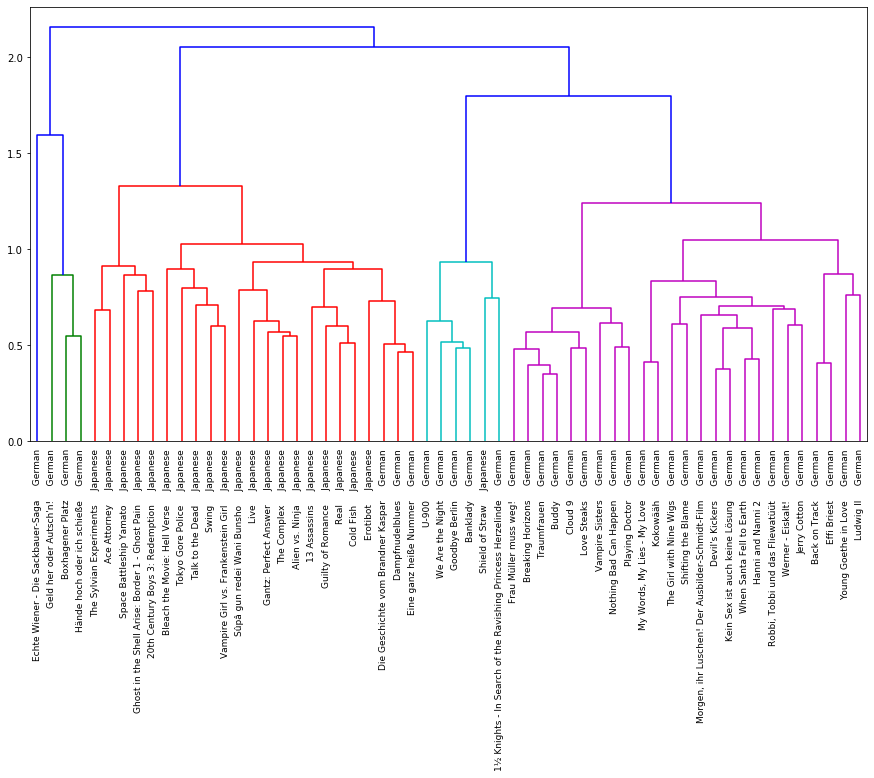

In [104]:
lmatrix = linkage_matrix(tokens.shape[0], hier_model.children_, hier_model.distances_)
plt.figure(figsize=(15,8))
dendrogram(lmatrix, labels=(df_sample['Title'].values + "     " + df_sample['Language'].values), leaf_font_size=9);

Gute Aufteilung in japanische (rot) und deutsche (violettt) Filme. Zwei große Ausreißergruppen sichtbar: Türkis enthält Musik Filme und der kleine Ausreißerbereich links im Cluster enthält deutsche Filme, die in Dialekt untertitelt wurden. Aufgrund der dialektischen Schreibweise der Wortformen werden diese nicht zusammen mit den anderen deutschen Filmen geclustert

## Auswertung mit Worthäufigkeitslisten

## Liste der Häufigsten Wortformen in expliziten Filmen

In [121]:
count_singletitle, text_singletitle, df_singletitle = wordlistersingle_Language('Eine ganz heiße Nummer')
print(sum(count_singletitle.values()))
count_singletitle.most_common(40)

3241


[('ja', 81),
 ('s', 50),
 ('schon', 45),
 ('maria', 31),
 ('hast', 29),
 ('lena', 26),
 ('waltraud', 26),
 ('gott', 24),
 ('mal', 24),
 ('gut', 22),
 ('geht', 20),
 ('nein', 19),
 ('hallo', 18),
 ('ganz', 18),
 ('mann', 17),
 ('mehr', 15),
 ('stöhnt', 15),
 ('klingelt', 14),
 ('jakob', 14),
 ('handy', 14),
 ('kannst', 14),
 ('heinz', 14),
 ('stöhnen', 14),
 ('herr', 13),
 ('flüstert', 13),
 ('mama', 13),
 ('lumpi', 13),
 ('geh', 12),
 ('grüß', 12),
 ('weiß', 12),
 ('gibt', 12),
 ('kommt', 12),
 ('halt', 12),
 ('dekan', 12),
 ('telefon', 11),
 ('tut', 11),
 ('mach', 11),
 ('bisschen', 11),
 ('immer', 11),
 ('gerti', 11)]

## Liste der Häufigsten Wortformen in den deutschen Filmen

In [100]:
count_german = wordlister_Language('German')
count_german.most_common(20)

[('ja', 2750),
 ('mal', 1490),
 ('hast', 886),
 ('s', 870),
 ('schon', 853),
 ('musik', 770),
 ('nein', 747),
 ('gut', 683),
 ('komm', 677),
 ('mann', 672),
 ('na', 574),
 ('geht', 558),
 ('los', 554),
 ('bitte', 540),
 ('mehr', 477),
 ('ganz', 469),
 ('immer', 468),
 ('weiß', 448),
 ('frau', 414),
 ('danke', 410)]

## Liste der Häufigsten Wortformen in den japanischen Filmen

In [101]:
count_japanese = wordlister_Language('Japanese')
count_japanese.most_common(20)

[('ja', 632),
 ('schon', 327),
 ('hast', 324),
 ('mal', 297),
 ('s', 294),
 ('gut', 263),
 ('bitte', 246),
 ('nein', 237),
 ('los', 195),
 ('mehr', 191),
 ('freund', 188),
 ('immer', 174),
 ('wer', 170),
 ('welt', 166),
 ('geht', 150),
 ('herr', 150),
 ('wurde', 149),
 ('leben', 138),
 ('weiß', 133),
 ('gehen', 130)]

### Fazit:
Die Unterscheidung von deutscher zu japanischer Sprache ist möglich. Die Sprachen lassen sich mittels hierarchischem Clustering gut unterscheiden. Ebenso zeigen die Worthäufigkeitslisten einige distinktive Wörter, anhand denen die zwischen den Sprachen differenziert werden kann. Die SPrache ist aber wie erwarte durch die Genre Untersuchungen zuvor nicht das einzige Signal, dass von den Texten ausgeht (Siehe Musik-Cluster)

# 3. Cluster über zusammengefasster Texte der einzelnen Genre
## Zusammenfassen der Texte

In [20]:
data=[]
texts =[]
genres=[]
for genre in df.genre.unique():
    text = ""
    for instance in df.iterrows():
        if instance[1].genre == genre:
            text = text + instance[1].text
    data.append({
                'genre': genre,
                'text': text,                            
            })
df_genre = pd.DataFrame.from_dict(data)
print(df_genre.shape)
df_genre.head()

(352, 2)


,genre,text
0,"Adventure,Drama,History",Der Roman von Alexandre Dumas dem Älteren hatt...
1,Comedy,Hände hoch oder ich schieße ( 1966 ) dTV - MDR...
2,Drama,"Hallo , Manuela ? Störe ich ? Kann ich zu dir ..."
3,"Action,Adventure",Dein Vater war ein ausgezeichneter Kämpfer . A...
4,Action,"Na los , iss jetzt schnell auf . Junge , ist d..."


In [21]:
df_genre.dropna(subset=['genre'], inplace=True)

### Prüfen ob die Texte korrekt zusammengefasst wurden

In [22]:
genre_test = "Action"
for x in df_genre.iterrows():
    if x[1].genre == genre_test:
        print(len(x[1].text))

text = ""
for instance in df.iterrows():
    if instance[1].genre == genre_test:
        text = text + instance[1].text
print(len(text))

1117565
1117565


## Erste Exploration mittels PCA

In [23]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=100, stop_words=stop_words)
tokens = tfidf.fit_transform(df_genre.text)

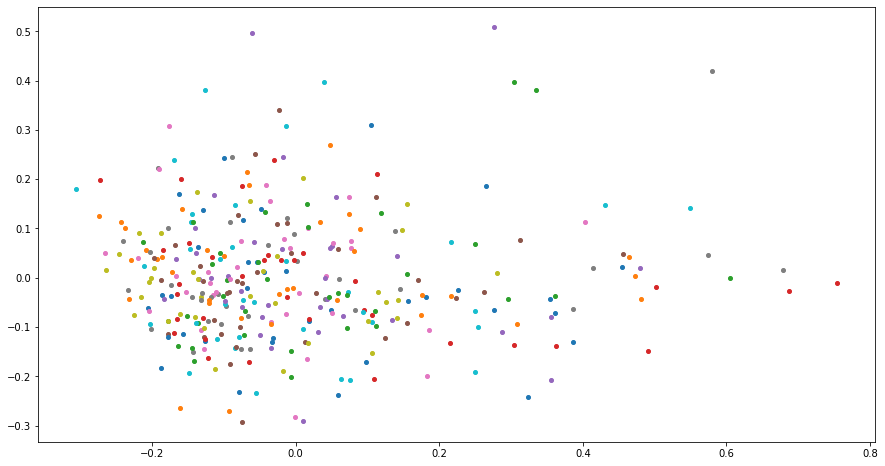

In [24]:
pca = PCA(n_components=2)
pca.fit(tokens.todense())
X_tf = pca.transform(tokens.todense())

#Abspeichern der Zwischenergebnisste im Datafram
df_genre['pcatokens_1'] = X_tf[:,0]
df_genre['pcatokens_2'] = X_tf[:,1]

#Plotten anhand der gespeicherten Zwischenergebnisse 
plt.figure(figsize=(15,8))
for d in df_genre.iterrows():
    x = d[1].pcatokens_1
    y = d[1].pcatokens_2    
    plt.plot(x, y, 'o', markersize=4)
    #plt.plot(x, y, marker=TextPath((-3, -3), f'{d[1].kmeanstokens}'), color='black', markersize=1)

## Exploration mittels Plotly
### Ineraktive Grafik - um diese Anzeigen zu können muss das Notebook neu ausgeführt werden

In [25]:
import plotly.graph_objects as go
import plotly.express as px
text_data = [
    f'{row.genre}|'
    for index, row in df_genre.iterrows()
]
fig = go.Figure(data=go.Scatter(x=X_tf[:, 0],
                                y=X_tf[:, 1],
                                mode='markers',
                                text=text_data))
fig.show()

## Hierarchisches Cluster der zusammengefassten Genres

In [26]:
df_genre_sample = df_genre.sample(frac=0.2)

In [27]:
tfidf = TfidfVectorizer(max_features=10000, stop_words=stop_words)
df_genre_token = tfidf.fit_transform(df_genre_sample.text)

hier_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(df_genre_token.todense())

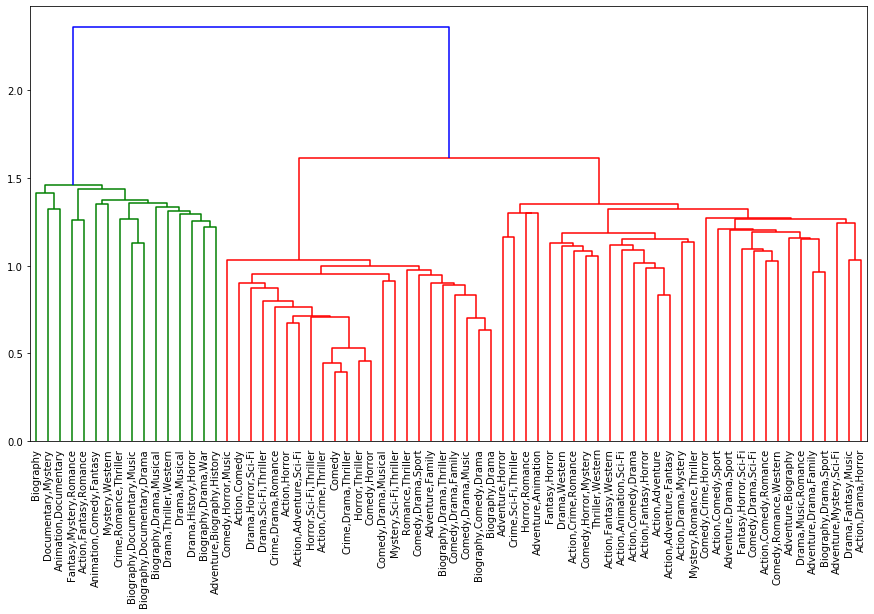

In [28]:
lmatrix = linkage_matrix(df_genre_token.shape[0], hier_model.children_, hier_model.distances_)
plt.figure(figsize=(15,8))
dendrogram(lmatrix, labels=df_genre_sample['genre'].values, leaf_font_size=10); #

### Fazit: 
Erste Einblicke in die Daten mittels PCA waren noch nicht vielversprechend, die Interaktiven Methoden von Plotly ermöglichten aber einen guten Überblick über die Verteilung der Genres.
Das hierarchische Clustering ordnet viele Genre, die eine Textuelle Nähe vermuten lassen in mehrere "gute" aber nicht allzu übersichtliche Cluster. Auffällig ist aber, dass viele Genre, in denen man Intuitiv eine Textuelle Nähe erwarten kann oft relativ "weit" voneinander geclustert wurden (siehe beispielsweise diverse Genre, die Sci-fi enthalten)